In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# original one 66.66%
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from keras.layers import Input
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
from keras.models import Model
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

In [ ]:
# Load the dataset

df = pd.read_excel('/content/drive/MyDrive/aspect_sentiment_dataset_final.xlsx')
df = df.drop(columns=['Unnamed: 0'], axis=1)
print("Data size: ", df.shape)
df[:10]

### Worldcloud

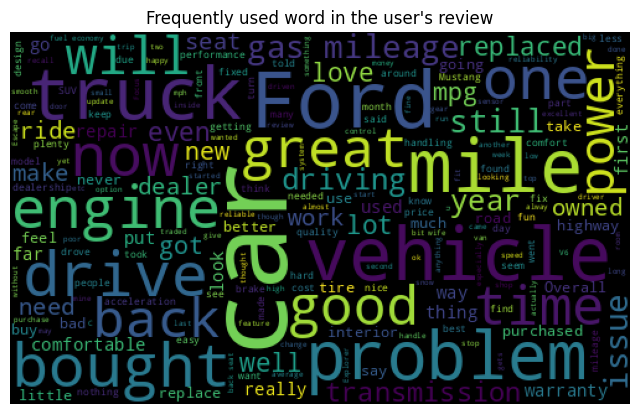

In [ ]:
words = ' '.join([s for s in df['review']])
wordcloud = WordCloud(width=500, height=300, random_state=20, max_font_size=90).generate(words)

plt.figure(figsize=(8,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Frequently used word in the user's review")
plt.show()

### Plot aspect frequency

Text(0.5, 1.0, 'Frequncy of aspect')

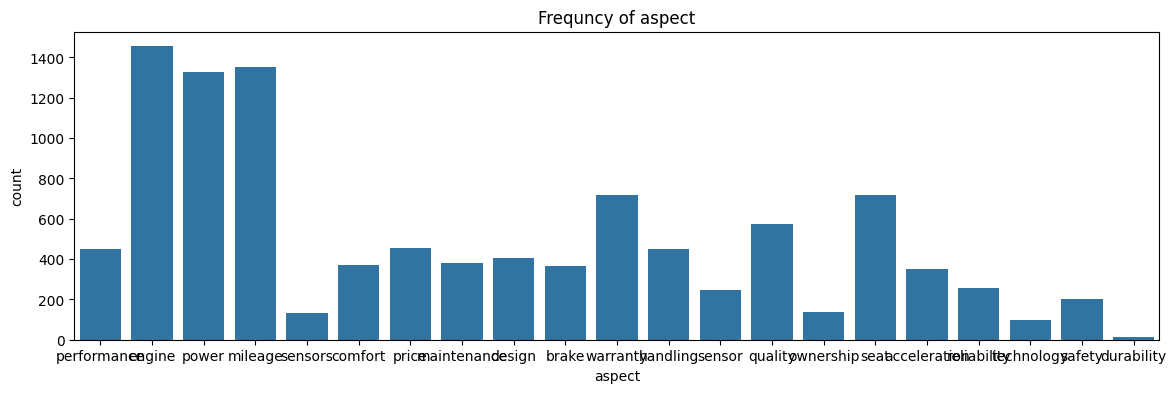

In [ ]:
plt.figure(figsize=(14,4))
sns.countplot(x=df['aspect'])
plt.title("Frequncy of aspect")

#### Plot output label frequency

In [ ]:
df['aspect_sentiment'].value_counts()

positive    5823
neutral     2590
negative    1965
Name: aspect_sentiment, dtype: int64

Text(0.5, 1.0, 'Frequncy of sentiment(output label)')

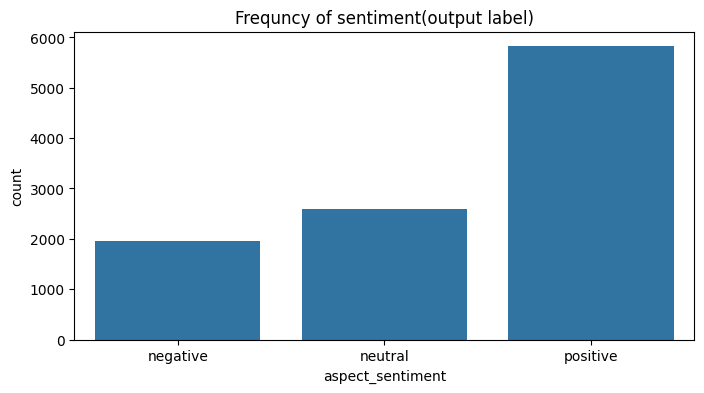

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x=df['aspect_sentiment'])
plt.title("Frequncy of sentiment(output label)")

# Preprocesing

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Preprocessing
def preprocess_text(text):
    # remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


In [ ]:
df['review'] = df['review'].apply(preprocess_text)
df['aspect'] = df['aspect'].apply(preprocess_text)


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['review'].values + df['aspect'].values)

# Convert text to sequences
X_review = tokenizer.texts_to_sequences(df['review'].values)
X_aspect = tokenizer.texts_to_sequences(df['aspect'].values)

In [ ]:
# Pad sequences
max_sequence_length = 100
X_review = pad_sequences(X_review, maxlen=max_sequence_length)
X_aspect = pad_sequences(X_aspect, maxlen=max_sequence_length)

# Label encoding
y = pd.get_dummies(df['aspect_sentiment']).values

# Train-test split


In [ ]:
X_train_review, X_test_review, X_train_aspect, X_test_aspect, y_train, y_test = train_test_split(
    X_review, X_aspect, y, test_size=0.2, random_state=42)

In [ ]:

# Define CNN model
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

# Review input
review_input = Input(shape=(max_sequence_length,))
review_embedding = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(review_input)
review_conv = Conv1D(32, 3, activation='relu')(review_embedding) # 32, 64, 3, 3, epoch 6
review_conv = Conv1D(64, 3, activation='relu')(review_conv)
# review_conv = Conv1D(128, 3, activation='relu')(review_conv)
review_pooling = GlobalMaxPooling1D()(review_conv)

# Aspect input
aspect_input = Input(shape=(max_sequence_length,))
aspect_embedding = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(aspect_input)
aspect_conv = Conv1D(32, 3, activation='relu')(aspect_embedding)
aspect_conv = Conv1D(64, 3, activation='relu')(aspect_conv)
# aspect_conv = Conv1D(128, 3, activation='relu')(aspect_conv)
aspect_pooling = GlobalMaxPooling1D()(aspect_conv)

# Concatenate two features
merged = concatenate([review_pooling, aspect_pooling])

dense = Dense(32, activation='relu')(merged) # 32, 64, 128 epoch 6 with 2 dropout layer
dropout = Dropout(0.2)(dense)
dense = Dense(64, activation='relu')(dropout)
dropout = Dropout(0.2)(dense)
dense = Dense(128, activation='relu')(dropout)
output = Dense(3, activation='softmax')(dropout)

model = Model(inputs=[review_input, aspect_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 100, 100)             2330600   ['input_17[0][0]']            
                                                                                                  
 embedding_17 (Embedding)    (None, 100, 100)             2330600   ['input_18[0][0]']            
                                                                                            

In [ ]:
# Train the model
epochs = 8
batch_size = 32
checkpoint = ModelCheckpoint('aspect_cnn_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train_review, X_train_aspect], y_train, validation_data=([X_test_review, X_test_aspect], y_test),
                    epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])

Epoch 1/8
262/262 [==============================] - ETA: 0s - loss: 0.9065 - accuracy: 0.5919
Epoch 1: val_accuracy improved from -inf to 0.65504, saving model to aspect_cnn_model.hdf5
262/262 [==============================] - 27s 97ms/step - loss: 0.9065 - accuracy: 0.5919 - val_loss: 0.7920 - val_accuracy: 0.6550


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/8
262/262 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7002
Epoch 2: val_accuracy improved from 0.65504 to 0.70712, saving model to aspect_cnn_model.hdf5
262/262 [==============================] - 22s 85ms/step - loss: 0.7050 - accuracy: 0.7002 - val_loss: 0.7288 - val_accuracy: 0.7071
Epoch 3/8
262/262 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7874
Epoch 3: val_accuracy improved from 0.70712 to 0.71142, saving model to aspect_cnn_model.hdf5
262/262 [==============================] - 27s 103ms/step - loss: 0.5526 - accuracy: 0.7874 - val_loss: 0.7451 - val_accuracy: 0.7114
Epoch 4/8
262/262 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8550
Epoch 4: val_accuracy improved from 0.71142 to 0.72193, saving model to aspect_cnn_model.hdf5
262/262 [==============================] - 24s 93ms/step - loss: 0.4180 - accuracy: 0.8550 - val_loss: 0.7550 - val_accuracy: 0.7219
Epoch 5/8
262/262 [==============

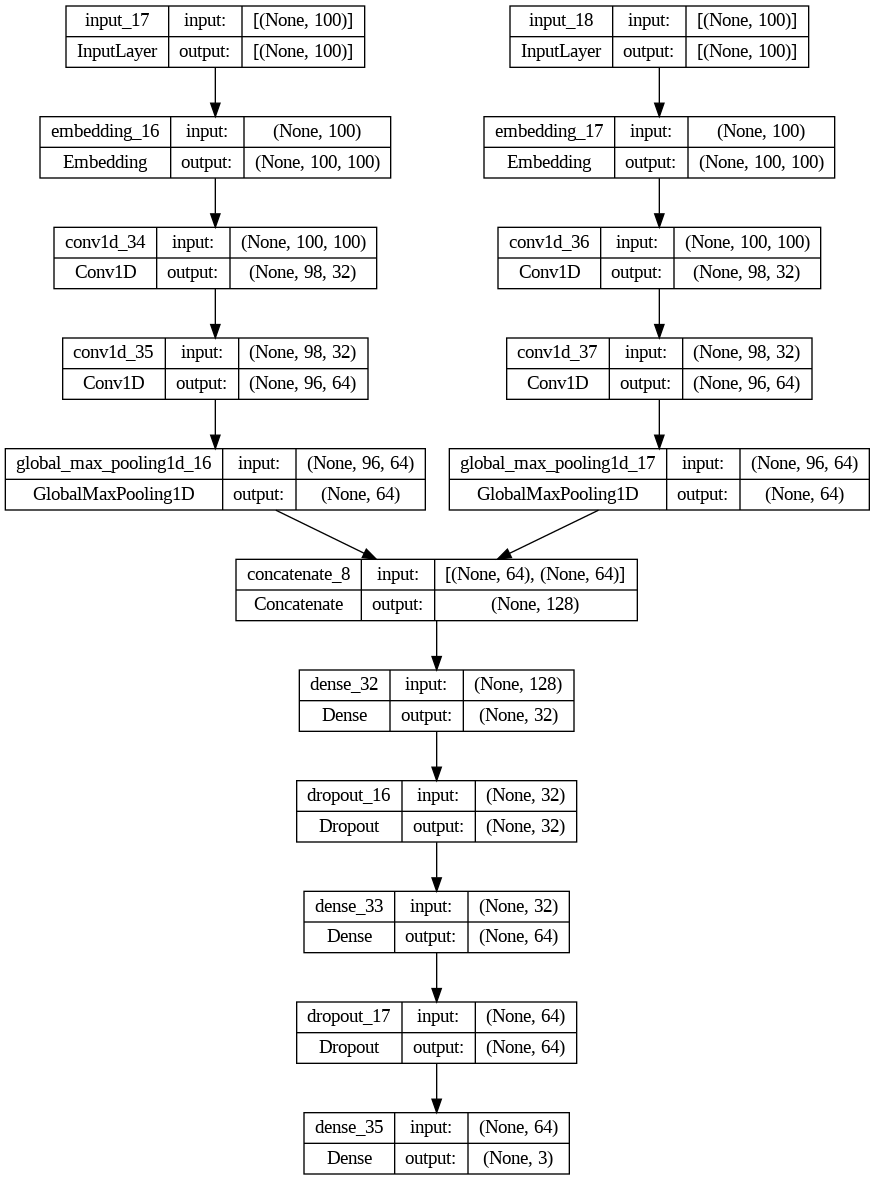

In [ ]:

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Load the best model weights
model.load_weights('aspect_cnn_model.hdf5')

# Evaluate the model
y_pred = model.predict([X_test_review, X_test_aspect])
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

66/66 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.81      0.45      0.58       422
           1       0.63      0.71      0.67       528
           2       0.80      0.88      0.84      1143

    accuracy                           0.75      2093
   macro avg       0.75      0.68      0.70      2093
weighted avg       0.76      0.75      0.74      2093

[[ 191  108  123]
 [  24  377  127]
 [  20  115 1008]]
Accuracy: 75.30%


66/66 [==============================] - 0s 7ms/step


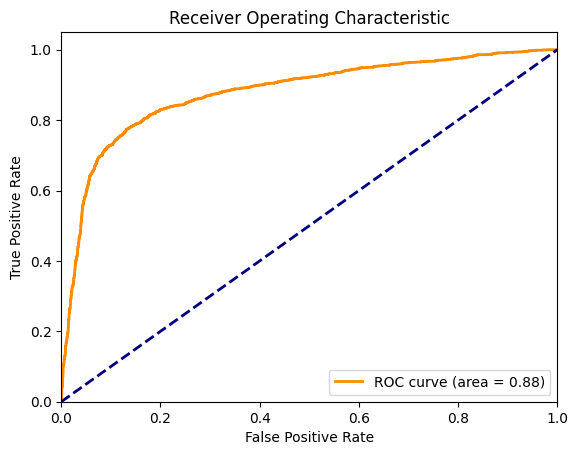

In [ ]:
# ROC curve
y_scores = model.predict([X_test_review, X_test_aspect])
fpr, tpr, _ = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


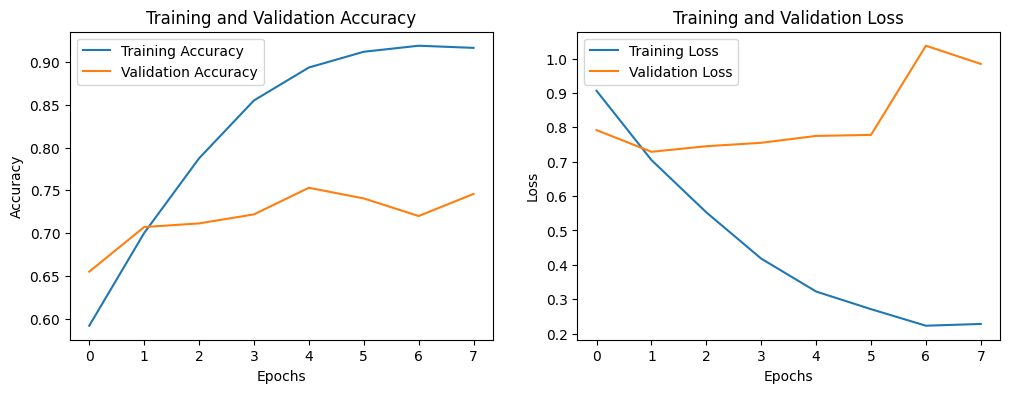

In [ ]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()